In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
## Analyze the selected song data and prepare it for the model 
## This notebook is used to prepare the data for the model. It is not used in the model itself. 
## The data is prepared in the following steps:
## 1. Load the data

## load the midi files from the songs folder 

import os 
import glob 
import pickle 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import music21 as m21

from tqdm import tqdm
from music21 import converter, instrument, note, chord, stream
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools

In [ ]:

!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

## Getting the Lakh MIDI Dataset ##

source: https://nbviewer.org/github/craffel/midi-dataset/blob/master/Tutorial.ipynb 

In [18]:
import os 
# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = '.'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

In [26]:
with open(SCORE_FILE) as f:
    scores = json.load(f)
# Grab a Million Song Dataset ID from the scores dictionary
msd_id = scores.keys()
msd_id = list(msd_id)
print(len(msd_id))

31034


## Installation stuff ## 


In [19]:
## Installation stuff ## 

!pip install -q git+https://github.com/tensorflow/docs
!pip install llvmlite --ignore installed 
!pip install tensorflow-addons
!pip install --upgrade --ignore-installed tensorflow
!pip -q imageio
!pip install librosa 
!pip install tensorflow
!pip install numba==0.53 --user


In [1]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

c:\Users\JingHong Huang\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\JingHong Huang\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\JingHong Huang\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\JingHong Huang\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
train_size = 60000
BATCH_SIZE = 10
test_size = 10000
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

BASE_PATH = '../swifty-music/metadata/genres_original'

## Data Preprocessing ##


In [4]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [5]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [6]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

## Sample an original music ##

In [7]:
import librosa
librosa.show_versions()

INSTALLED VERSIONS
------------------
python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

librosa: 0.10.0.post2

audioread: 3.0.0
numpy: 1.23.5
scipy: 1.10.1


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


sklearn: 1.0.2
joblib: 1.1.0
decorator: 5.1.1
numba: 0.53.0
soundfile: 0.12.1
pooch: v1.6.0
soxr: 0.3.5
typing_extensions: installed, no version number available
lazy_loader: installed, no version number available
msgpack: installed, no version number available

numpydoc: 1.2
sphinx: 4.4.0
sphinx_rtd_theme: None
matplotlib: 3.5.1
sphinx_multiversion: None
sphinx_gallery: None
mir_eval: None
ipython: None
sphinxcontrib.rsvgconverter: None
pytest: 7.1.1
pytest_mpl: None
pytest_cov: None
samplerate: None
resampy: None
presets: None
packaging: 23.1


In [10]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

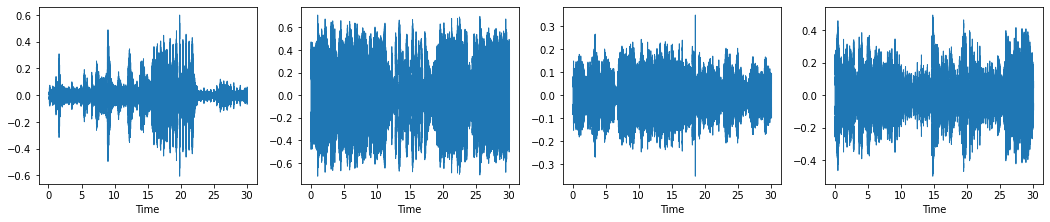

In [12]:
# waveplot is NOW waveshow
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveshow(j[0], sr=3000)